In [3]:
import os
import yaml
import cv2
import glob
import matplotlib.pyplot as plt

def combine_yolo_datasets():
    datasets = [
        'data/Geometric Shape.v2i.yolov8',
        'data/object-detection.v2i.yolov8',
        'data/shapes.v1i.yolov8',
        'data/hexagon.v1-hexagon_1.yolov8'
    ]

    target_classes = ['square', 'triangle', 'hexagon', 'circle']

    output_dir = 'data/drone_plane_yolo_dataset'

    for split in ['train', 'valid', 'test']:
        os.makedirs(f'{output_dir}/{split}/images', exist_ok=True)
        os.makedirs(f'{output_dir}/{split}/labels', exist_ok=True)

    dataset_info = {}

    for dataset in datasets:
        try:
            with open(f'{dataset}/data.yaml', 'r') as f:
                config = yaml.safe_load(f)
                classes = [name.lower().strip() for name in config['names']]

                class_mapping = {}
                for old_id, class_name in enumerate(classes):
                    if class_name in target_classes:
                        new_id = target_classes.index(class_name)
                        class_mapping[old_id] = new_id
                    else:
                        class_mapping[old_id] = None

                dataset_info[dataset] = {
                    'classes': classes,
                    'mapping': class_mapping
                }

                print(f"Dataset: {dataset}")
                print(f"  Original classes: {classes}")
                print(f"  Class mapping: {class_mapping}")

        except Exception as e:
            print(f"Error reading {dataset}/data.yaml: {e}")
            continue

    print(f"\nTarget classes: {target_classes}")
    print(f"Total target classes: {len(target_classes)}")

    file_counter = 0
    total_labels_kept = 0
    total_labels_skipped = 0

    for dataset in datasets:
        if dataset not in dataset_info:
            continue

        dataset_short = dataset.split('/')[-1].split('.')[0]
        mapping = dataset_info[dataset]['mapping']

        print(f"\nProcessing {dataset_short}")

        for split in ['train', 'valid', 'test']:
            img_dir = f'{dataset}/{split}/images'
            lbl_dir = f'{dataset}/{split}/labels'

            if not os.path.exists(img_dir):
                print(f"  {split}: directory not found")
                continue

            files_processed = 0
            images_with_valid_labels = 0

            for img_file in os.listdir(img_dir):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    continue

                try:
                    label_name = os.path.splitext(img_file)[0] + '.txt'
                    src_label_path = os.path.join(lbl_dir, label_name)

                    valid_labels = []

                    if os.path.exists(src_label_path):
                        with open(src_label_path, 'r') as f:
                            lines = f.readlines()

                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                old_id = int(parts[0])
                                new_id = mapping.get(old_id)

                                if new_id is not None:
                                    valid_labels.append(f"{new_id} {' '.join(parts[1:])}\n")
                                    total_labels_kept += 1
                                else:
                                    total_labels_skipped += 1

                    if valid_labels:
                        ext = os.path.splitext(img_file)[1]
                        new_filename = f"{dataset_short}_{file_counter:05d}{ext}"

                        src_img_path = os.path.join(img_dir, img_file)
                        dst_img_path = os.path.join(output_dir, split, 'images', new_filename)

                        img = cv2.imread(src_img_path)
                        if img is None:
                            print(f"    Cannot read: {img_file}")
                            continue

                        success = cv2.imwrite(dst_img_path, img)
                        if not success:
                            print(f"    Cannot write: {new_filename}")
                            continue

                        dst_label_name = os.path.splitext(new_filename)[0] + '.txt'
                        dst_label_path = os.path.join(output_dir, split, 'labels', dst_label_name)

                        with open(dst_label_path, 'w') as f:
                            f.writelines(valid_labels)

                        files_processed += 1
                        file_counter += 1
                        images_with_valid_labels += 1

                except Exception as e:
                    print(f"    Error processing {img_file}: {e}")
                    continue

            print(f"  {split}: {files_processed} files processed, {images_with_valid_labels} with valid labels")

    config = {
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': len(target_classes),
        'names': target_classes
    }

    with open(f'{output_dir}/data.yaml', 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    config_test = {
        'train': 'train/images',
        'val': 'test/images',
        'nc': len(target_classes),
        'names': target_classes
    }

    with open(f'{output_dir}/test_data.yaml', 'w') as f:
        yaml.dump(config_test, f, default_flow_style=False)


    print(f"\n" + "="*50)
    print(f"FILTERING COMPLETE!")
    print(f"Output directory: {output_dir}")
    print(f"Total images with target classes: {file_counter}")
    print(f"Labels kept: {total_labels_kept}")
    print(f"Labels skipped: {total_labels_skipped}")
    print(f"Target classes: {target_classes}")

    print(f"\nFinal dataset statistics:")
    for split in ['train', 'valid', 'test']:
        img_count = len([f for f in os.listdir(f'{output_dir}/{split}/images') if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        lbl_count = len([f for f in os.listdir(f'{output_dir}/{split}/labels') if f.endswith('.txt')])
        print(f"  {split}: {img_count} images, {lbl_count} labels")

In [4]:
combine_yolo_datasets()

Dataset: data/Geometric Shape.v2i.yolov8
  Original classes: ['circle', 'ellipse', 'hexagon', 'pentagon', 'quatrefoil', 'rectangle', 'rhombus', 'square', 'star', 'triangle']
  Class mapping: {0: 3, 1: None, 2: 2, 3: None, 4: None, 5: None, 6: None, 7: 0, 8: None, 9: 1}
Dataset: data/object-detection.v2i.yolov8
  Original classes: ['circle', 'cross', 'hexagon', 'pentagon', 'rectangle', 'semicircle', 'square', 'star', 'triangle']
  Class mapping: {0: 3, 1: None, 2: 2, 3: None, 4: None, 5: None, 6: 0, 7: None, 8: 1}
Dataset: data/shapes.v1i.yolov8
  Original classes: ['circle', 'hexagon', 'rectangle', 'square', 'triangle']
  Class mapping: {0: 3, 1: 2, 2: None, 3: 0, 4: 1}
Dataset: data/hexagon.v1-hexagon_1.yolov8
  Original classes: ['hexagon']
  Class mapping: {0: 2}

Target classes: ['square', 'triangle', 'hexagon', 'circle']
Total target classes: 4

Processing Geometric Shape
  train: 1708 files processed, 1708 with valid labels
  valid: 60 files processed, 60 with valid labels
  test

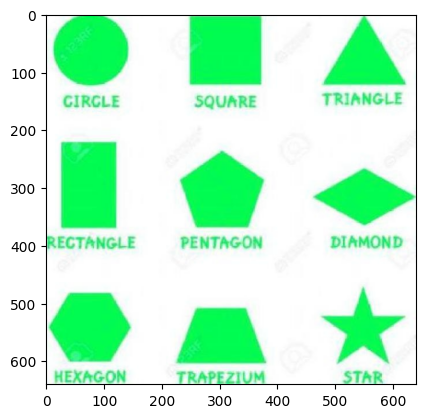

In [25]:
files = glob.glob("data/drone_plane_yolo_dataset/test/images/*.jpg")
file = files[31]

img = cv2.imread(file, cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

### Renaming

In [ ]:
files = glob.glob("../test_photos/*.png")

for i, file in enumerate(files):
    print(f"Processing {file}")
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    cv2.imwrite(f"to_yolo_labeling/shapes_eval_{i}.jpg", img)